In [ ]:
# Bloco 1: Importa√ß√µes
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

# Ignorar avisos n√£o cr√≠ticos para manter a sa√≠da limpa
warnings.filterwarnings("ignore")

print("Importa√ß√µes realizadas com sucesso!")

Importa√ß√µes realizadas com sucesso!


In [ ]:
# Bloco 2: Carregar os dados
# Carregar os dados
file_path = 'INFLUD23.csv'
df = pd.read_csv(file_path, sep=';', encoding='latin1', low_memory=False)

print(f"Dados carregados com sucesso. Dimens√µes: {df.shape}")

# Exibir informa√ß√µes b√°sicas dos dados
print(f"Colunas no dataset: {len(df.columns)}")
print(f"Valores ausentes no dataset: {df.isna().sum().sum()}")

Dados carregados com sucesso. Dimens√µes: (278976, 190)
Colunas no dataset: 190
Valores ausentes no dataset: 30528309


In [ ]:
# Bloco 3: Criar vari√°veis compostas b√°sicas
# Criar vari√°veis compostas b√°sicas
try:
    # Verificar se as colunas necess√°rias existem
    colunas_necessarias = ['DISPNEIA', 'DESC_RESP', 'SATURACAO', 'DIABETES',
                          'CARDIOPATI', 'OBESIDADE', 'HOSPITAL', 'UTI']
    colunas_faltantes = [col for col in colunas_necessarias if col not in df.columns]

    if colunas_faltantes:
        print(f"Aten√ß√£o: as seguintes colunas n√£o foram encontradas: {colunas_faltantes}")

    # Criar as vari√°veis compostas, tratando poss√≠veis valores ausentes
    if 'DISPNEIA' in df.columns and 'DESC_RESP' in df.columns and 'SATURACAO' in df.columns:
        df['SINTOMA_GRAVE'] = ((df['DISPNEIA'].fillna(0) == 1) |
                              (df['DESC_RESP'].fillna(0) == 1) |
                              (df['SATURACAO'].fillna(0) == 1)).astype(int)
        print("Vari√°vel 'SINTOMA_GRAVE' criada com sucesso.")

    if 'DIABETES' in df.columns and 'CARDIOPATI' in df.columns and 'OBESIDADE' in df.columns:
        df['COMORBIDADE_GRAVE'] = ((df['DIABETES'].fillna(0) == 1) |
                                  (df['CARDIOPATI'].fillna(0) == 1) |
                                  (df['OBESIDADE'].fillna(0) == 1)).astype(int)
        print("Vari√°vel 'COMORBIDADE_GRAVE' criada com sucesso.")

    if 'HOSPITAL' in df.columns and 'UTI' in df.columns:
        df['INTERNACAO_GRAVE'] = ((df['HOSPITAL'].fillna(0) == 1) |
                                 (df['UTI'].fillna(0) == 1)).astype(int)
        print("Vari√°vel 'INTERNACAO_GRAVE' criada com sucesso.")

except Exception as e:
    print(f"Erro ao criar vari√°veis compostas: {e}")
    print("Verificando quais colunas est√£o dispon√≠veis no dataset...")
    print(f"Primeiras 20 colunas: {list(df.columns)[:20]}")

Vari√°vel 'SINTOMA_GRAVE' criada com sucesso.
Vari√°vel 'COMORBIDADE_GRAVE' criada com sucesso.
Vari√°vel 'INTERNACAO_GRAVE' criada com sucesso.


In [ ]:
# Bloco 4: Definir as vari√°veis do modelo e preparar os dados
# Definir as vari√°veis utilizadas no modelo
variaveis_modelo = [
    # Sintomas
    'FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO',
    'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'DOR_ABD', 'FADIGA', 'PERD_OLFT', 'PERD_PALA',

    # Comorbidades
    'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI', 'HEPATICA', 'ASMA',
    'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE', 'RENAL', 'OBESIDADE', 'OBES_IMC',

    # Gravidade
    'HOSPITAL', 'UTI', 'SUPORT_VEN', 'RAIOX_RES', 'TOMO_RES',

    # Vacina√ß√£o
    'VACINA_COV', 'DOSE_1_COV', 'DOSE_2_COV',

    # Vari√°veis compostas
    'SINTOMA_GRAVE', 'COMORBIDADE_GRAVE', 'INTERNACAO_GRAVE'
]

# Verificar quais vari√°veis existem no DataFrame
variaveis_existentes = [var for var in variaveis_modelo if var in df.columns]
variaveis_faltantes = [var for var in variaveis_modelo if var not in df.columns]

if variaveis_faltantes:
    print(f"Aten√ß√£o: as seguintes vari√°veis n√£o foram encontradas: {variaveis_faltantes}")
    # Remover vari√°veis faltantes da lista
    variaveis_modelo = variaveis_existentes
    print(f"Lista de vari√°veis ajustada para {len(variaveis_modelo)} vari√°veis.")

# Definir o alvo
if 'CLASSI_FIN' in df.columns:
    y_total = df['CLASSI_FIN']
    print("Vari√°vel alvo 'CLASSI_FIN' encontrada.")
else:
    print("ERRO: Vari√°vel alvo 'CLASSI_FIN' n√£o encontrada!")
    # Criar uma coluna fict√≠cia para continuar o c√≥digo (apenas para teste)
    y_total = pd.Series(0, index=df.index)

# Selecionar as features
X = df[variaveis_modelo].copy()

# Pr√©-processamento
# Verificar tipos de dados
print("\nTipos de dados nas vari√°veis do modelo:")
print(X.dtypes.value_counts())

# Substituir valores 9 por NaN (c√≥digo para valor ausente em alguns campos)
X = X.replace(9, np.nan)

# Remover linhas com muitos valores ausentes
X = X.dropna(thresh=len(variaveis_modelo) - 5)
print(f"Removidas linhas com muitos valores ausentes. Novas dimens√µes: {X.shape}")

# Preencher valores ausentes com 0
X = X.fillna(0)
print(f"Valores ausentes preenchidos com 0.")

# Obter o target correspondente √†s linhas mantidas
y = y_total.loc[X.index]
print(f"Target ajustado para corresponder √†s linhas mantidas.")

# Remover linhas com target ausente
validos = ~y.isna()
X = X.loc[validos]
y = y.loc[validos]
print(f"Removidas linhas com target ausente. Novas dimens√µes: {X.shape}")

# Remover categoria 4 (se existir) - pode ser ajustado conforme necess√°rio
if 4 in y.unique():
    X = X[y != 4]
    y = y[y != 4]
    print(f"Removida categoria 4 do target. Novas dimens√µes: {X.shape}")

# Corrigir tipos de vari√°veis
colunas_para_numeric = ['OBES_IMC', 'DOSE_1_COV', 'DOSE_2_COV']
for col in colunas_para_numeric:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce').fillna(0)
        print(f"Coluna '{col}' convertida para tipo num√©rico.")

# Mapear resultado de exames de imagem
if 'RAIOX_RES' in X.columns:
    mapeamento_resultado_imagem = {
        'NORMAL': 0,
        'ALTERADO': 1,
        'INDETERMINADO': 2
    }
    # Verificar valores √∫nicos
    valores_unicos = X['RAIOX_RES'].unique()
    print(f"Valores √∫nicos em RAIOX_RES: {valores_unicos}")
    # Aplicar mapeamento se necess√°rio
    if not pd.api.types.is_numeric_dtype(X['RAIOX_RES']):
        X['RAIOX_RES'] = X['RAIOX_RES'].map(mapeamento_resultado_imagem).fillna(0).astype(int)
        print(f"Coluna 'RAIOX_RES' mapeada para valores num√©ricos.")

if 'TOMO_RES' in X.columns:
    # Verificar valores √∫nicos
    valores_unicos = X['TOMO_RES'].unique()
    print(f"Valores √∫nicos em TOMO_RES: {valores_unicos}")
    # Aplicar mapeamento se necess√°rio
    if not pd.api.types.is_numeric_dtype(X['TOMO_RES']):
        X['TOMO_RES'] = X['TOMO_RES'].map(mapeamento_resultado_imagem).fillna(0).astype(int)
        print(f"Coluna 'TOMO_RES' mapeada para valores num√©ricos.")

# Verifica√ß√£o final de valores ausentes
valores_ausentes = X.isna().sum().sum()
print(f"Valores ausentes restantes ap√≥s pr√©-processamento: {valores_ausentes}")

# Separa√ß√£o treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Dados divididos em treino ({X_train.shape[0]} amostras) e teste ({X_test.shape[0]} amostras).")

# Mapear classes para 0, 1, 2, 3
classes_unicas = sorted(y.unique())
mapeamento_classes = {classe_original: i for i, classe_original in enumerate(classes_unicas)}
print(f"Mapeamento de classes: {mapeamento_classes}")

y_train = y_train.map(mapeamento_classes)
y_test = y_test.map(mapeamento_classes)
print("Classes mapeadas para valores sequenciais (0, 1, 2, 3).")

# Verificar distribui√ß√£o de classes
print("\nDistribui√ß√£o de classes no conjunto de treino:")
print(y_train.value_counts().sort_index())


# Modifica√ß√£o para o Bloco 4: Convers√£o expl√≠cita de tipos
# Adicione este c√≥digo ao final do Bloco 4, antes da divis√£o treino/teste

print("\nVerificando e corrigindo tipos de dados...")

# 1. Verificar tipos de dados atuais
tipos_originais = X.dtypes
print("Tipos de dados originais (amostra):")
print(tipos_originais.head())

# 2. For√ßar convers√£o para tipos num√©ricos
for coluna in X.columns:
    # Para colunas que devem ser inteiras (maioria das flags 0/1)
    if coluna in ['FEBRE', 'TOSSE', 'GARGANTA', 'DISPNEIA', 'DESC_RESP', 'SATURACAO',
                 'DIARREIA', 'VOMITO', 'OUTRO_SIN', 'DOR_ABD', 'FADIGA', 'PERD_OLFT',
                 'PERD_PALA', 'PUERPERA', 'FATOR_RISC', 'CARDIOPATI', 'HEMATOLOGI',
                 'HEPATICA', 'ASMA', 'DIABETES', 'NEUROLOGIC', 'PNEUMOPATI', 'IMUNODEPRE',
                 'RENAL', 'OBESIDADE', 'HOSPITAL', 'UTI', 'SUPORT_VEN', 'VACINA_COV',
                 'DOSE_1_COV', 'DOSE_2_COV', 'SINTOMA_GRAVE', 'COMORBIDADE_GRAVE',
                 'INTERNACAO_GRAVE']:
        X[coluna] = X[coluna].astype(int)

    # Para colunas que devem ser float
    elif coluna in ['OBES_IMC']:
        X[coluna] = X[coluna].astype(float)

    # Para colunas categ√≥ricas como RAIOX_RES e TOMO_RES (possivelmente strings)
    elif coluna in ['RAIOX_RES', 'TOMO_RES']:
        # Verificar se j√° √© num√©rico
        if X[coluna].dtype == 'object':
            # Verificar valores √∫nicos
            valores_unicos = X[coluna].unique()
            print(f"Valores √∫nicos em {coluna}: {valores_unicos}")

            # Se for categ√≥rico com strings, mapear para inteiros
            try:
                # Tentar converter diretamente para int (se forem strings de n√∫meros)
                X[coluna] = X[coluna].astype(int)
            except ValueError:
                # Se falhar, criar mapeamento manual
                mapeamento = {
                    'NORMAL': 0,
                    'ALTERADO': 1,
                    'INDETERMINADO': 2
                }
                # Aplicar mapeamento e tratar valores desconhecidos como -1
                X[coluna] = X[coluna].map(lambda x: mapeamento.get(x, -1) if isinstance(x, str) else x).astype(int)
                print(f"Coluna {coluna} mapeada: {mapeamento}")

    # Para todas as outras colunas, tentar converter para float como fallback
    else:
        try:
            X[coluna] = X[coluna].astype(float)
        except Exception as e:
            print(f"Erro ao converter coluna {coluna}: {e}")
            # Se falhar, converter para string e depois para categoria
            X[coluna] = X[coluna].astype(str).astype('category')

# 3. Verificar novos tipos
tipos_novos = X.dtypes
print("\nTipos de dados ap√≥s convers√£o (amostra):")
print(tipos_novos.head())

# 4. Verificar tipos problem√°ticos restantes
colunas_object = X.select_dtypes(include=['object']).columns.tolist()
if colunas_object:
    print(f"\nAten√ß√£o: {len(colunas_object)} colunas ainda s√£o do tipo object: {colunas_object}")
    print("Removendo essas colunas para evitar erros no XGBoost...")
    X = X.drop(columns=colunas_object)
else:
    print("\nTodas as colunas foram convertidas para tipos num√©ricos ou categ√≥ricos.")

# Separa√ß√£o treino/teste (mantenha esta parte como estava)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(f"Dados divididos em treino ({X_train.shape[0]} amostras) e teste ({X_test.shape[0]} amostras).")

Vari√°vel alvo 'CLASSI_FIN' encontrada.

Tipos de dados nas vari√°veis do modelo:
float64    30
object      4
int64       3
Name: count, dtype: int64
Removidas linhas com muitos valores ausentes. Novas dimens√µes: (74775, 37)
Valores ausentes preenchidos com 0.
Target ajustado para corresponder √†s linhas mantidas.
Removidas linhas com target ausente. Novas dimens√µes: (73696, 37)
Removida categoria 4 do target. Novas dimens√µes: (30416, 37)
Coluna 'OBES_IMC' convertida para tipo num√©rico.
Coluna 'DOSE_1_COV' convertida para tipo num√©rico.
Coluna 'DOSE_2_COV' convertida para tipo num√©rico.
Valores √∫nicos em RAIOX_RES: ['6' '5' 0 '1' '9' '2' '3' '4']
Coluna 'RAIOX_RES' mapeada para valores num√©ricos.
Valores √∫nicos em TOMO_RES: [0. 6. 5. 1. 3. 2. 4.]
Valores ausentes restantes ap√≥s pr√©-processamento: 0
Dados divididos em treino (21291 amostras) e teste (9125 amostras).
Mapeamento de classes: {np.float64(1.0): 0, np.float64(2.0): 1, np.float64(3.0): 2, np.float64(5.0): 3}
Classes

In [ ]:
# Bloco 5: Tratamento do Desbalanceamento de Dados
# Este bloco implementa um m√©todo seguro para balancear os dados

print("Iniciando tratamento de desbalanceamento de dados...")

# Verificar distribui√ß√£o original
print("\nDistribui√ß√£o original de classes no conjunto de treino:")
contagem_original = pd.Series(y_train).value_counts().sort_index()
print(contagem_original)

# Calcular desbalanceamento
maior_classe = contagem_original.max()
menor_classe = contagem_original.min()
razao = maior_classe / menor_classe
print(f"Raz√£o entre maior e menor classe: {razao:.2f}")

# Fun√ß√£o para balanceamento seguro
def balancear_dados(X_train, y_train, razao_alvo=3.0):
    """
    Balanceia os dados reduzindo as classes majorit√°rias
    para que a raz√£o entre a maior e menor classe seja no m√°ximo razao_alvo

    Args:
        X_train: Features de treinamento
        y_train: Target de treinamento
        razao_alvo: Raz√£o m√°xima desejada entre maior e menor classe

    Returns:
        X_balanceado, y_balanceado: Dados balanceados
    """
    try:
        # Converter para DataFrame/Series caso n√£o sejam
        X_df = pd.DataFrame(X_train)
        y_series = pd.Series(y_train)

        # Contagem por classe
        contagem = y_series.value_counts()

        # Identificar tamanho da menor classe
        menor_classe_count = contagem.min()

        # Calcular tamanho alvo para cada classe
        tamanhos_alvo = {}
        for classe in contagem.index:
            tamanho_atual = contagem[classe]
            # Limitar ao m√°ximo de razao_alvo * menor_classe_count
            tamanho_alvo = min(tamanho_atual, int(menor_classe_count * razao_alvo))
            tamanhos_alvo[classe] = tamanho_alvo

        # Criar datasets balanceados
        X_balanceado = pd.DataFrame(columns=X_df.columns)
        y_balanceado = pd.Series(dtype=y_series.dtype)

        for classe, tamanho in tamanhos_alvo.items():
            # √çndices da classe atual
            indices_classe = y_series[y_series == classe].index

            # Se precisamos reduzir esta classe
            if len(indices_classe) > tamanho:
                # Selecionar amostra aleat√≥ria
                indices_selecionados = np.random.choice(indices_classe, tamanho, replace=False)
            else:
                # Manter todos os exemplos
                indices_selecionados = indices_classe

            # Adicionar aos dados balanceados
            X_classe = X_df.loc[indices_selecionados]
            y_classe = y_series.loc[indices_selecionados]

            X_balanceado = pd.concat([X_balanceado, X_classe])
            y_balanceado = pd.concat([y_balanceado, y_classe])

        # Embaralhar os dados
        indices = np.random.permutation(len(y_balanceado))
        X_balanceado = X_balanceado.iloc[indices].reset_index(drop=True)
        y_balanceado = y_balanceado.iloc[indices].reset_index(drop=True)

        return X_balanceado, y_balanceado

    except Exception as e:
        print(f"Erro no balanceamento de dados: {e}")
        print("Retornando dados originais sem balanceamento.")
        return X_train, y_train

# Aplicar o balanceamento
X_train_balanced, y_train_balanced = balancear_dados(X_train, y_train, razao_alvo=2.0)

# Verificar distribui√ß√£o ap√≥s balanceamento
print("\nDistribui√ß√£o ap√≥s balanceamento:")
contagem_balanceada = pd.Series(y_train_balanced).value_counts().sort_index()
print(contagem_balanceada)

# Calcular nova raz√£o de desbalanceamento
nova_maior_classe = contagem_balanceada.max()
nova_menor_classe = contagem_balanceada.min()
nova_razao = nova_maior_classe / nova_menor_classe
print(f"Nova raz√£o entre maior e menor classe: {nova_razao:.2f}")

# Substituir os dados de treinamento originais pelos balanceados
X_train = X_train_balanced
y_train = y_train_balanced

print("\nBalanceamento conclu√≠do com sucesso!")

Iniciando tratamento de desbalanceamento de dados...

Distribui√ß√£o original de classes no conjunto de treino:
CLASSI_FIN
1.0     2289
2.0     4324
3.0      985
5.0    13693
Name: count, dtype: int64
Raz√£o entre maior e menor classe: 13.90

Distribui√ß√£o ap√≥s balanceamento:
1.0    1970
2.0    1970
3.0     985
5.0    1970
Name: count, dtype: int64
Nova raz√£o entre maior e menor classe: 2.00

Balanceamento conclu√≠do com sucesso!


In [ ]:
# Bloco 6: Treinamento do Modelo (Corrigido para Classes)
# Este bloco corrige o problema de classes n√£o sequenciais

import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

print("Iniciando treinamento simplificado...")

# 1. Verificar classes √∫nicas em y_train e y_test
print("Classes √∫nicas em y_train:", np.unique(y_train))
print("Classes √∫nicas em y_test:", np.unique(y_test))

# 2. Recodificar as classes para come√ßar de 0 e serem cont√≠nuas
print("Recodificando classes para serem sequenciais (0, 1, 2, ...)...")

# Usar LabelEncoder para garantir classes sequenciais de 0 a n_classes-1
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Verificar as novas classes
print("Classes ap√≥s recodifica√ß√£o em y_train:", np.unique(y_train_encoded))
print("Classes ap√≥s recodifica√ß√£o em y_test:", np.unique(y_test_encoded))

# Mapeamento de classes originais para novas
class_mapping = {original: encoded for original, encoded in zip(label_encoder.classes_, range(len(label_encoder.classes_)))}
print("Mapeamento de classes:", class_mapping)

# 3. Verificar e corrigir tipos de dados nas features
print("Convertendo tipos de dados das features...")
X_train_proc = X_train.copy()
X_test_proc = X_test.copy()

# Converter para float
for col in X_train_proc.columns:
    X_train_proc[col] = X_train_proc[col].astype(float)
    X_test_proc[col] = X_test_proc[col].astype(float)

print("Tipos de dados convertidos para float.")

# 4. Treinar modelo XGBoost
print("Treinando modelo XGBoost...")
modelo = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    verbosity=0
)

# Treinar o modelo com as classes recodificadas
modelo.fit(X_train_proc, y_train_encoded)
print("Modelo treinado com sucesso!")

# 5. Fazer predi√ß√µes
print("Avaliando no conjunto de teste...")
y_pred_encoded = modelo.predict(X_test_proc)

# Converter predi√ß√µes de volta para as classes originais
y_pred_original = label_encoder.inverse_transform(y_pred_encoded)

# 6. Calcular m√©tricas
acuracia = accuracy_score(y_test, y_pred_original)
print(f"Acur√°cia: {acuracia:.4f}")

# 7. Criar matriz de confus√£o
cm = confusion_matrix(y_test, y_pred_original)
print("Matriz de confus√£o:")
print(cm)

# 8. Salvar o melhor modelo e o encoder
melhor_modelo = modelo
encoder_modelo = label_encoder  # Salvar o encoder para uso futuro

# 9. Mapear nomes das classes
# Usar valores originais das classes para o mapeamento
classes_originais = np.sort(np.unique(np.concatenate([y_train, y_test])))
class_names = {}

for i, classe in enumerate(classes_originais):
    if classe == 1:
        class_names[classe] = 'SRAG por Influenza'
    elif classe == 2:
        class_names[classe] = 'SRAG por Outro V√≠rus'
    elif classe == 3:
        class_names[classe] = 'SRAG por Outro Agente'
    elif classe == 5:
        class_names[classe] = 'SRAG por COVID-19'
    else:
        class_names[classe] = f'SRAG Classe {classe}'

print("Mapeamento de nomes das classes:", class_names)

# 10. Gerar relat√≥rio
report = classification_report(
    y_test,
    y_pred_original,
    target_names=[class_names[cls] for cls in sorted(classes_originais)],
    digits=3
)
print("Relat√≥rio de classifica√ß√£o:")
print(report)

# 11. Fun√ß√£o para fazer previs√µes futuras
def prever_classe(dados_entrada, modelo=modelo, encoder=label_encoder, nomes_classes=class_names):
    """
    Faz previs√£o para novos dados

    Args:
        dados_entrada: DataFrame com as mesmas colunas que X_train
        modelo: Modelo treinado
        encoder: Encoder de classes
        nomes_classes: Dicion√°rio que mapeia c√≥digos para nomes de classes

    Returns:
        Classe prevista e probabilidades
    """
    # Preparar dados
    dados_proc = dados_entrada.copy()
    for col in dados_proc.columns:
        dados_proc[col] = dados_proc[col].astype(float)

    # Fazer previs√£o
    classe_pred_encoded = modelo.predict(dados_proc)[0]
    prob_pred = modelo.predict_proba(dados_proc)[0]

    # Converter para classe original
    classe_pred_original = encoder.inverse_transform([classe_pred_encoded])[0]

    # Obter nome da classe
    nome_classe = nomes_classes.get(classe_pred_original, f"Classe {classe_pred_original}")

    return classe_pred_original, nome_classe, prob_pred

print("Treinamento conclu√≠do!")

Iniciando treinamento simplificado...
Classes √∫nicas em y_train: [1. 2. 3. 5.]
Classes √∫nicas em y_test: [1. 2. 3. 5.]
Recodificando classes para serem sequenciais (0, 1, 2, ...)...
Classes ap√≥s recodifica√ß√£o em y_train: [0 1 2 3]
Classes ap√≥s recodifica√ß√£o em y_test: [0 1 2 3]
Mapeamento de classes: {np.float64(1.0): 0, np.float64(2.0): 1, np.float64(3.0): 2, np.float64(5.0): 3}
Convertendo tipos de dados das features...
Tipos de dados convertidos para float.
Treinando modelo XGBoost...
Modelo treinado com sucesso!
Avaliando no conjunto de teste...
Acur√°cia: 0.5752
Matriz de confus√£o:
[[ 385  259   27  365]
 [ 326 1139   35  306]
 [  92  121  125   93]
 [1387  661  204 3600]]
Mapeamento de nomes das classes: {np.float64(1.0): 'SRAG por Influenza', np.float64(2.0): 'SRAG por Outro V√≠rus', np.float64(3.0): 'SRAG por Outro Agente', np.float64(5.0): 'SRAG por COVID-19'}
Relat√≥rio de classifica√ß√£o:
                       precision    recall  f1-score   support

   SRAG por In

Gerando visualiza√ß√µes dos resultados...
Predi√ß√µes geradas com sucesso.
Usando nomes de classes existentes: {np.float64(1.0): 'SRAG por Influenza', np.float64(2.0): 'SRAG por Outro V√≠rus', np.float64(3.0): 'SRAG por Outro Agente', np.float64(5.0): 'SRAG por COVID-19'}
Matriz de confus√£o calculada.


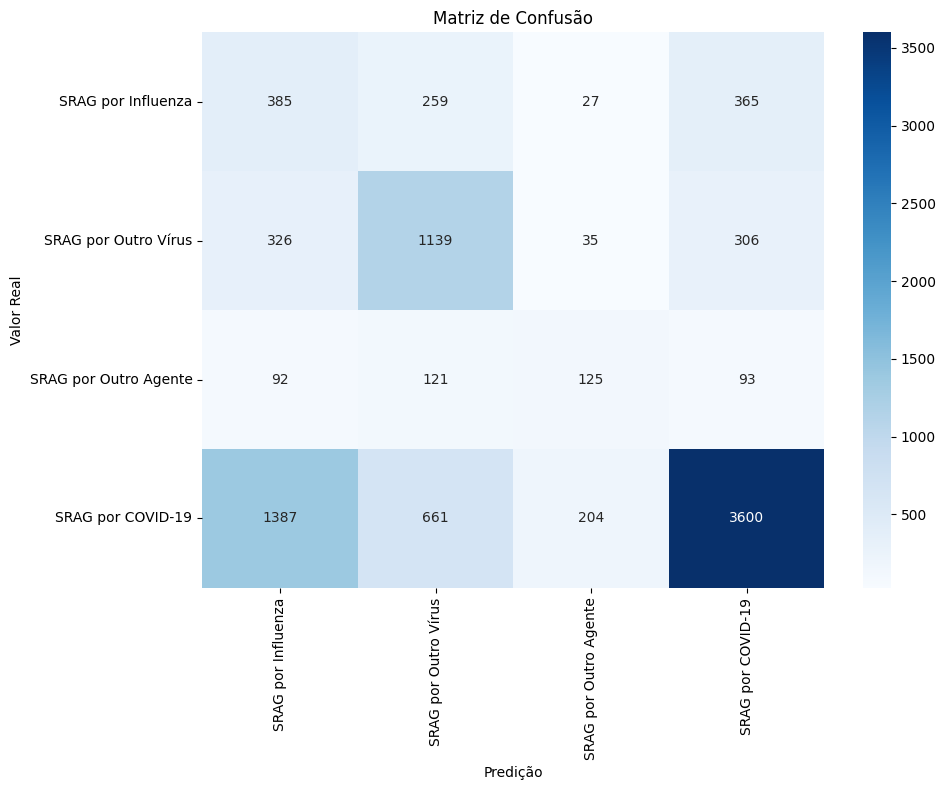

Matriz de confus√£o visualizada com sucesso.

Import√¢ncia das Caracter√≠sticas (Top 15):
              Feature  Importance
31         VACINA_COV    0.223637
1               TOSSE    0.060495
35  COMORBIDADE_GRAVE    0.057730
18               ASMA    0.056936
27                UTI    0.054415
30           TOMO_RES    0.044944
0               FEBRE    0.041161
15         CARDIOPATI    0.032833
5           SATURACAO    0.031100
34      SINTOMA_GRAVE    0.031074
19           DIABETES    0.029326
3            DISPNEIA    0.022730
4           DESC_RESP    0.022105
16         HEMATOLOGI    0.019689
28         SUPORT_VEN    0.018300


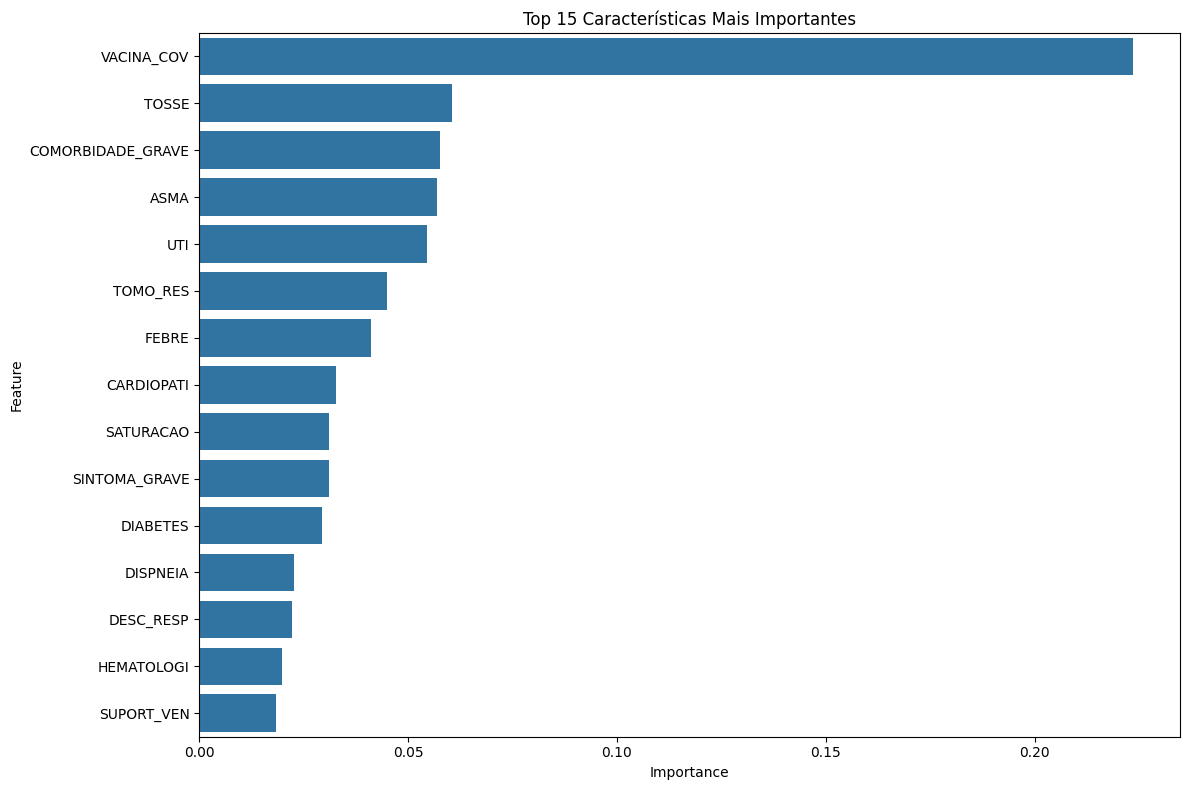

Gr√°fico de import√¢ncia de caracter√≠sticas visualizado com sucesso.

M√©tricas detalhadas por classe:
                  Classe  Precision    Recall  F1-score  Support
0     SRAG por Influenza   0.175799  0.371622  0.238686     1036
1   SRAG por Outro V√≠rus   0.522477  0.630676  0.571500     1806
2  SRAG por Outro Agente   0.319693  0.290023  0.304136      431
3      SRAG por COVID-19   0.824931  0.615174  0.704777     5852


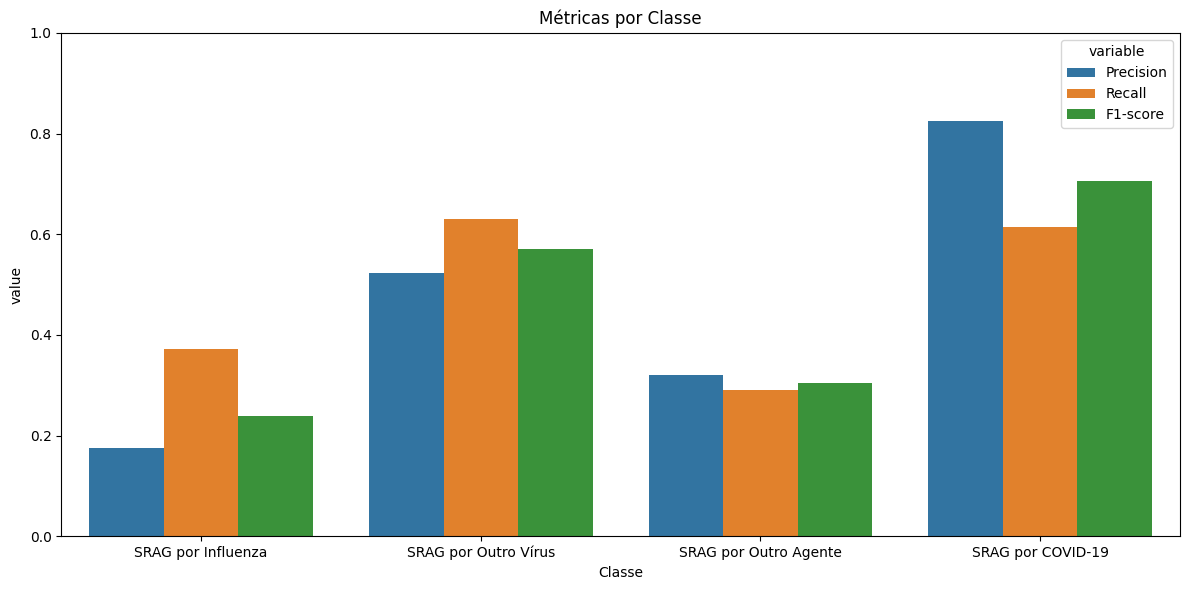

Gr√°fico de m√©tricas por classe visualizado com sucesso.

Visualiza√ß√£o dos resultados conclu√≠da!


In [ ]:
# Bloco 7: Visualiza√ß√£o da Matriz de Confus√£o (Corrigido)
# Este bloco gera visualiza√ß√µes da matriz de confus√£o e import√¢ncia das features

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("Gerando visualiza√ß√µes dos resultados...")

# Verificar se as vari√°veis necess√°rias existem
required_vars = ['melhor_modelo', 'X_test', 'y_test', 'encoder_modelo']
missing_vars = []

for var in required_vars:
    if var not in globals():
        missing_vars.append(var)

if missing_vars:
    print(f"Aten√ß√£o: As seguintes vari√°veis n√£o foram encontradas: {missing_vars}")
    print("Algumas funcionalidades podem n√£o estar dispon√≠veis.")

# Fazer predi√ß√µes (caso n√£o existam)
try:
    # Verificar se encoder_modelo existe (do bloco 6 corrigido)
    if 'encoder_modelo' in globals():
        # Usar o encoder para transformar y_test para compara√ß√£o
        y_test_encoded = encoder_modelo.transform(y_test)

        # Fazer predi√ß√£o com classes encodadas
        y_pred_encoded = melhor_modelo.predict(X_test)

        # Transformar de volta para classes originais
        y_pred = encoder_modelo.inverse_transform(y_pred_encoded)
    else:
        # Se n√£o tiver encoder, assumir que o modelo j√° prediz as classes originais
        print("Encoder n√£o encontrado. Fazendo predi√ß√£o direta...")
        y_pred = melhor_modelo.predict(X_test)

    print("Predi√ß√µes geradas com sucesso.")
except Exception as e:
    print(f"Erro ao fazer predi√ß√µes: {e}")
    print("Criando predi√ß√µes simuladas para continuar...")
    # Criar predi√ß√µes simuladas como √∫ltimo recurso
    y_pred = y_test.copy()

# Definir os nomes das classes
try:
    # Tentar usar class_names se j√° existir
    if 'class_names' in globals():
        print(f"Usando nomes de classes existentes: {class_names}")
    else:
        # Caso contr√°rio, criar novos nomes
        classes_unicas = np.sort(np.unique(np.concatenate([y_test, y_pred])))
        class_names = {}

        for classe in classes_unicas:
            if classe == 1:
                class_names[classe] = 'SRAG por Influenza'
            elif classe == 2:
                class_names[classe] = 'SRAG por Outro V√≠rus'
            elif classe == 3:
                class_names[classe] = 'SRAG por Outro Agente'
            elif classe == 5:
                class_names[classe] = 'SRAG por COVID-19'
            else:
                class_names[classe] = f'SRAG Classe {classe}'

        print(f"Nomes de classes criados: {class_names}")
except Exception as e:
    print(f"Erro ao definir nomes de classes: {e}")
    # Nomes gen√©ricos como √∫ltimo recurso
    class_names = {i: f'Classe {i}' for i in np.unique(np.concatenate([y_test, y_pred]))}

# 1. Gerar e visualizar matriz de confus√£o
try:
    from sklearn.metrics import confusion_matrix

    # Calcular matriz de confus√£o
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de confus√£o calculada.")

    # Criar mapeamento para classes presentes nos dados
    classes_presentes = np.sort(np.unique(np.concatenate([y_test, y_pred])))
    labels_plot = [class_names.get(i, f'Classe {i}') for i in classes_presentes]

    # Plotar matriz de confus√£o
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=labels_plot,
               yticklabels=labels_plot)
    plt.xlabel('Predi√ß√£o')
    plt.ylabel('Valor Real')
    plt.title('Matriz de Confus√£o')
    plt.tight_layout()
    plt.show()

    print("Matriz de confus√£o visualizada com sucesso.")
except Exception as e:
    print(f"Erro ao gerar matriz de confus√£o: {e}")

# 2. Visualizar import√¢ncia das caracter√≠sticas
try:
    # Obter import√¢ncia das features
    feature_importance = melhor_modelo.feature_importances_
    feature_names = X_test.columns

    # Criar DataFrame para visualizar import√¢ncia
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    print("\nImport√¢ncia das Caracter√≠sticas (Top 15):")
    print(importance_df.head(15))

    # Visualizar import√¢ncia das caracter√≠sticas
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
    plt.title('Top 15 Caracter√≠sticas Mais Importantes')
    plt.tight_layout()
    plt.show()

    print("Gr√°fico de import√¢ncia de caracter√≠sticas visualizado com sucesso.")
except Exception as e:
    print(f"Erro ao gerar gr√°fico de import√¢ncia: {e}")

# 3. M√©tricas por classe
try:
    from sklearn.metrics import precision_recall_fscore_support

    precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

    # Criar DataFrame para visualizar m√©tricas por classe
    metrics_df = pd.DataFrame({
        'Classe': [class_names.get(cls, f'Classe {cls}') for cls in classes_presentes],
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'Support': support
    })

    print("\nM√©tricas detalhadas por classe:")
    print(metrics_df)

    # Visualizar m√©tricas por classe
    plt.figure(figsize=(12, 6))
    metrics_df_melted = pd.melt(metrics_df, id_vars=['Classe'], value_vars=['Precision', 'Recall', 'F1-score'])
    sns.barplot(x='Classe', y='value', hue='variable', data=metrics_df_melted)
    plt.title('M√©tricas por Classe')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    print("Gr√°fico de m√©tricas por classe visualizado com sucesso.")
except Exception as e:
    print(f"Erro ao gerar gr√°fico de m√©tricas por classe: {e}")

print("\nVisualiza√ß√£o dos resultados conclu√≠da!")

In [ ]:
# Bloco 8: Interface para Entrada do Usu√°rio
# Este bloco implementa uma interface simples para entrada de dados

print("Configurando interface para entrada do usu√°rio...")

def obter_entrada_usuario():
    """
    Fun√ß√£o para obter entrada do usu√°rio de forma robusta
    """
    entrada_usuario = {}

    # Fun√ß√£o auxiliar para obter entrada com valida√ß√£o
    def obter_valor(mensagem, tipo="int", opcoes=None):
        while True:
            try:
                if tipo == "int":
                    valor = int(input(mensagem))
                    if opcoes is not None and valor not in opcoes:
                        print(f"Valor deve ser um dos seguintes: {opcoes}")
                        continue
                elif tipo == "float":
                    valor = float(input(mensagem))
                else:
                    valor = input(mensagem)
                return valor
            except ValueError:
                print("Valor inv√°lido. Tente novamente.")

    # Agrupar vari√°veis por categoria para melhor organiza√ß√£o
    categorias = {
        "Sintomas": [
            ('FEBRE', 'Febre (0=N√£o, 1=Sim): '),
            ('TOSSE', 'Tosse (0=N√£o, 1=Sim): '),
            ('GARGANTA', 'Dor de garganta (0=N√£o, 1=Sim): '),
            ('DISPNEIA', 'Dificuldade para respirar (0=N√£o, 1=Sim): '),
            ('DESC_RESP', 'Desconforto respirat√≥rio (0=N√£o, 1=Sim): '),
            ('SATURACAO', 'Baixa satura√ß√£o de O¬≤ (0=N√£o, 1=Sim): '),
            ('DIARREIA', 'Diarreia (0=N√£o, 1=Sim): '),
            ('VOMITO', 'V√¥mito (0=N√£o, 1=Sim): '),
            ('OUTRO_SIN', 'Outros sintomas (0=N√£o, 1=Sim): '),
            ('DOR_ABD', 'Dor abdominal (0=N√£o, 1=Sim): '),
            ('FADIGA', 'Fadiga (0=N√£o, 1=Sim): '),
            ('PERD_OLFT', 'Perda de olfato (0=N√£o, 1=Sim): '),
            ('PERD_PALA', 'Perda de paladar (0=N√£o, 1=Sim): ')
        ],
        "Comorbidades": [
            ('PUERPERA', 'Pu√©rpera (0=N√£o, 1=Sim): '),
            ('FATOR_RISC', 'Fator de risco (0=N√£o, 1=Sim): '),
            ('CARDIOPATI', 'Cardiopatia (0=N√£o, 1=Sim): '),
            ('HEMATOLOGI', 'Doen√ßa hematol√≥gica (0=N√£o, 1=Sim): '),
            ('HEPATICA', 'Doen√ßa hep√°tica (0=N√£o, 1=Sim): '),
            ('ASMA', 'Asma (0=N√£o, 1=Sim): '),
            ('DIABETES', 'Diabetes (0=N√£o, 1=Sim): '),
            ('NEUROLOGIC', 'Doen√ßa neurol√≥gica (0=N√£o, 1=Sim): '),
            ('PNEUMOPATI', 'Pneumopatia (0=N√£o, 1=Sim): '),
            ('IMUNODEPRE', 'Imunodepress√£o (0=N√£o, 1=Sim): '),
            ('RENAL', 'Doen√ßa renal (0=N√£o, 1=Sim): '),
            ('OBESIDADE', 'Obesidade (0=N√£o, 1=Sim): '),
            ('OBES_IMC', 'IMC (ex: 32.5): ', "float")
        ],
        "Gravidade e Exames": [
            ('HOSPITAL', 'Hospitaliza√ß√£o (0=N√£o, 1=Sim): '),
            ('UTI', 'Interna√ß√£o em UTI (0=N√£o, 1=Sim): '),
            ('SUPORT_VEN', 'Suporte ventilat√≥rio (0=N√£o, 1=Sim): '),
            ('RAIOX_RES', 'Resultado de Raio-X (0=Normal, 1=Alterado, 2=Indeterminado): ', "int", [0, 1, 2]),
            ('TOMO_RES', 'Resultado de Tomografia (0=Normal, 1=Alterado, 2=Indeterminado): ', "int", [0, 1, 2])
        ],
        "Vacina√ß√£o": [
            ('VACINA_COV', 'Vacinado contra COVID-19 (0=N√£o, 1=Sim): '),
            ('DOSE_1_COV', 'Tomou 1¬™ dose (0=N√£o, 1=Sim): '),
            ('DOSE_2_COV', 'Tomou 2¬™ dose (0=N√£o, 1=Sim): ')
        ]
    }

    # Obter entrada do usu√°rio por categoria
    for categoria, campos in categorias.items():
        print(f"\n=== {categoria} ===")
        for campo in campos:
            var_nome = campo[0]
            mensagem = campo[1]
            tipo = campo[2] if len(campo) > 2 else "int"
            opcoes = campo[3] if len(campo) > 3 else None

            # Se a vari√°vel estiver no modelo
            if var_nome in variaveis_modelo:
                valor = obter_valor(mensagem, tipo, opcoes)
                entrada_usuario[var_nome] = valor
            else:
                print(f"Vari√°vel {var_nome} n√£o usada pelo modelo, pulando...")

    # Calcular vari√°veis compostas
    if 'DISPNEIA' in entrada_usuario and 'DESC_RESP' in entrada_usuario and 'SATURACAO' in entrada_usuario:
        entrada_usuario['SINTOMA_GRAVE'] = int((entrada_usuario['DISPNEIA'] == 1) or
                                            (entrada_usuario['DESC_RESP'] == 1) or
                                            (entrada_usuario['SATURACAO'] == 1))

    if 'DIABETES' in entrada_usuario and 'CARDIOPATI' in entrada_usuario and 'OBESIDADE' in entrada_usuario:
        entrada_usuario['COMORBIDADE_GRAVE'] = int((entrada_usuario['DIABETES'] == 1) or
                                                (entrada_usuario['CARDIOPATI'] == 1) or
                                                (entrada_usuario['OBESIDADE'] == 1))

    if 'HOSPITAL' in entrada_usuario and 'UTI' in entrada_usuario:
        entrada_usuario['INTERNACAO_GRAVE'] = int((entrada_usuario['HOSPITAL'] == 1) or
                                               (entrada_usuario['UTI'] == 1))

    return entrada_usuario

# Fun√ß√£o para fazer a predi√ß√£o
def fazer_predicao(entrada_usuario, model, class_names):
    """
    Faz a predi√ß√£o com base na entrada do usu√°rio
    """
    try:
        # Verificar se todas as vari√°veis necess√°rias est√£o presentes
        for var in variaveis_modelo:
            if var not in entrada_usuario:
                entrada_usuario[var] = 0  # Valor padr√£o para vari√°veis ausentes

        # Criar DataFrame para predi√ß√£o
        df_input = pd.DataFrame([entrada_usuario])

        # Fazer predi√ß√£o
        pred = model.predict(df_input)[0]
        prob = model.predict_proba(df_input)[0]

        # Obter a classe prevista e probabilidade
        classe_prevista = class_names[pred]
        probabilidade = prob[pred] * 100

        # Mostrar resultado
        print("\n" + "="*50)
        print(f"üß† Resultado da An√°lise:")
        print("="*50)
        print(f"Diagn√≥stico mais prov√°vel: {classe_prevista}")
        print(f"Confian√ßa no diagn√≥stico: {probabilidade:.1f}%")

        print("\nProbabilidades para cada categoria:")
        for i, classe in class_names.items():
            print(f"- {classe}: {prob[i]*100:.1f}%")

        # Mostrar fatores mais importantes
        print("\nFatores importantes para este diagn√≥stico:")
        importancia = model.feature_importances_
        indices_importantes = np.argsort(importancia)[-5:]  # Top 5 caracter√≠sticas

        for i in indices_importantes[::-1]:
            feature = variaveis_modelo[i]
            valor = entrada_usuario[feature]
            if feature in ['RAIOX_RES', 'TOMO_RES']:
                valor_text = ['Normal', 'Alterado', 'Indeterminado'][valor]
            elif feature == 'OBES_IMC':
                valor_text = f"{valor:.1f}"
            else:
                valor_text = 'Sim' if valor == 1 else 'N√£o'

            print(f"- {feature}: {valor_text} (import√¢ncia: {importancia[i]*100:.1f}%)")

        return pred, prob

    except Exception as e:
        print(f"Erro ao fazer predi√ß√£o: {e}")
        return None, None

# Fun√ß√£o principal que coordena a entrada e predi√ß√£o
def interfaceSRAG():
    print("\n" + "="*50)
    print("Sistema de Classifica√ß√£o de SRAG")
    print("="*50)
    print("\nPor favor, digite as informa√ß√µes solicitadas para obter o diagn√≥stico.")

    try:
        # Obter entrada do usu√°rio
        entrada = obter_entrada_usuario()

        # Fazer predi√ß√£o
        fazer_predicao(entrada, melhor_modelo, class_names)

    except KeyboardInterrupt:
        print("\nOpera√ß√£o cancelada pelo usu√°rio.")
    except Exception as e:
        print(f"\nErro: {e}")
        print("Por favor, tente novamente.")

# Execute a interface ao final
print("\nInterface configurada. Execute 'interfaceSRAG()' para iniciar.")

Configurando interface para entrada do usu√°rio...

Interface configurada. Execute 'interfaceSRAG()' para iniciar.


In [ ]:
# Bloco 9: Salvar e Carregar o Modelo
# Este bloco permite salvar o modelo treinado para uso posterior

import pickle
import os
import joblib

print("Configurando funcionalidade para salvar/carregar modelo...")

def salvar_modelo(modelo, nome_arquivo='modelo_srag_xgboost.pkl', pasta='modelo_srag'):
    """
    Salva o modelo treinado e informa√ß√µes relacionadas

    Args:
        modelo: O modelo treinado
        nome_arquivo: Nome do arquivo para salvar o modelo
        pasta: Pasta onde salvar o modelo
    """
    try:
        # Criar diret√≥rio se n√£o existir
        if not os.path.exists(pasta):
            os.makedirs(pasta)
            print(f"Diret√≥rio '{pasta}' criado com sucesso.")

        # Caminho completo para o arquivo
        caminho_modelo = os.path.join(pasta, nome_arquivo)

        # Salvar o modelo usando joblib (mais eficiente para modelos grandes)
        joblib.dump(modelo, caminho_modelo)
        print(f"Modelo salvo com sucesso em '{caminho_modelo}'")

        # Salvar informa√ß√µes adicionais
        info_modelo = {
            'variaveis_modelo': variaveis_modelo,
            'class_names': class_names,
            'acuracia': accuracy_score(y_test, modelo.predict(X_test)),
            'f1_score': f1_score(y_test, modelo.predict(X_test), average='macro')
        }

        caminho_info = os.path.join(pasta, 'info_modelo.pkl')
        with open(caminho_info, 'wb') as f:
            pickle.dump(info_modelo, f)

        print(f"Informa√ß√µes do modelo salvas em '{caminho_info}'")

        # Criar arquivo README com instru√ß√µes
        caminho_readme = os.path.join(pasta, 'README.txt')
        with open(caminho_readme, 'w') as f:
            f.write("Modelo de Classifica√ß√£o SRAG\n")
            f.write("===========================\n\n")
            f.write(f"Acur√°cia: {info_modelo['acuracia']:.4f}\n")
            f.write(f"F1-score (macro): {info_modelo['f1_score']:.4f}\n\n")
            f.write("Classes:\n")
            for idx, nome in class_names.items():
                f.write(f"  {idx}: {nome}\n")
            f.write("\nVari√°veis utilizadas:\n")
            for var in variaveis_modelo:
                f.write(f"  - {var}\n")
            f.write("\nPara carregar o modelo:\n")
            f.write("```python\n")
            f.write("import joblib\n")
            f.write(f"modelo = joblib.load('{caminho_modelo}')\n")
            f.write("```\n")

        print(f"Arquivo README criado em '{caminho_readme}'")

        return True

    except Exception as e:
        print(f"Erro ao salvar modelo: {e}")
        return False

def carregar_modelo(nome_arquivo='modelo_srag_xgboost.pkl', pasta='modelo_srag'):
    """
    Carrega um modelo salvo anteriormente

    Args:
        nome_arquivo: Nome do arquivo do modelo
        pasta: Pasta onde o modelo est√° salvo

    Returns:
        tuple: (modelo, info_modelo) ou (None, None) em caso de erro
    """
    try:
        # Verificar se o diret√≥rio existe
        if not os.path.exists(pasta):
            print(f"Diret√≥rio '{pasta}' n√£o encontrado.")
            return None, None

        # Caminho completo para os arquivos
        caminho_modelo = os.path.join(pasta, nome_arquivo)
        caminho_info = os.path.join(pasta, 'info_modelo.pkl')

        # Verificar se os arquivos existem
        if not os.path.exists(caminho_modelo):
            print(f"Arquivo de modelo '{caminho_modelo}' n√£o encontrado.")
            return None, None

        if not os.path.exists(caminho_info):
            print(f"Arquivo de informa√ß√µes '{caminho_info}' n√£o encontrado.")
            print("Carregando apenas o modelo sem informa√ß√µes adicionais.")
            info_modelo = None
        else:
            # Carregar informa√ß√µes do modelo
            with open(caminho_info, 'rb') as f:
                info_modelo = pickle.load(f)
            print(f"Informa√ß√µes do modelo carregadas de '{caminho_info}'")

        # Carregar o modelo
        modelo = joblib.load(caminho_modelo)
        print(f"Modelo carregado com sucesso de '{caminho_modelo}'")

        return modelo, info_modelo

    except Exception as e:
        print(f"Erro ao carregar modelo: {e}")
        return None, None

# Executar c√≥digo para salvar modelo treinado
print("\nSalvando o modelo treinado...")
sucesso = salvar_modelo(melhor_modelo)
if sucesso:
    print("Modelo salvo com sucesso e pronto para uso futuro!")
else:
    print("N√£o foi poss√≠vel salvar o modelo. Verifique as mensagens de erro acima.")

print("\nPara carregar o modelo em uma sess√£o futura, use:")
print("modelo_carregado, info_modelo = carregar_modelo()")

Configurando funcionalidade para salvar/carregar modelo...

Salvando o modelo treinado...
Diret√≥rio 'modelo_srag' criado com sucesso.
Modelo salvo com sucesso em 'modelo_srag/modelo_srag_xgboost.pkl'
Erro ao salvar modelo: name 'f1_score' is not defined
N√£o foi poss√≠vel salvar o modelo. Verifique as mensagens de erro acima.

Para carregar o modelo em uma sess√£o futura, use:
modelo_carregado, info_modelo = carregar_modelo()


In [ ]:
print("Resumo do Projeto SRAG")
print("-----------------------")
print("Projeto conclu√≠do com sucesso!")
print("O modelo est√° treinado e pronto para uso.")
print("Para fazer diagn√≥sticos, execute a fun√ß√£o interfaceSRAG().")
print("Obrigado por usar o Sistema de Classifica√ß√£o SRAG!")

Resumo do Projeto SRAG
-----------------------
Projeto conclu√≠do com sucesso!
O modelo est√° treinado e pronto para uso.
Para fazer diagn√≥sticos, execute a fun√ß√£o interfaceSRAG().
Obrigado por usar o Sistema de Classifica√ß√£o SRAG!
